In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [3]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 27


In [4]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

In [5]:
# Split the dataset on train, development and test set.
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

block_size = 8  # how many charecters do we take to predict the next one?
Xtr, Ytr = build_dataset(words[:n1], block_size, True)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size, True) # 10%
Xte, Yte = build_dataset(words[n2:], block_size, True)     # 10%

Input: torch.Size([182597, 8]), Output: torch.Size([182597])
Input: torch.Size([22761, 8]), Output: torch.Size([22761])
Input: torch.Size([22788, 8]), Output: torch.Size([22788])


In [62]:
from typing import Any


class Linear():
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias      
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

class BatchNorm1d():
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wdith a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        if self.training:
            # check input's dimensionality
            if x.dim() == 2:
                dim = 0
            elif x.dim() == 3:
                dim = (0, 1)
            else:
                raise Exception(f'Able to process 2D or 3D tensors only, received {x.dim()}D tensor')
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1.0 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1.0 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding():
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX: torch.tensor) -> torch.tensor:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self) -> list[torch.tensor]:
        return [self.weight]
    

class FlattenConsecutive():
    def __init__(self, n: int) -> None:
        self.n = n  # number of consecutice elements

    def __call__(self, x: torch.tensor) -> torch.tensor:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return []
    

class Sequential():
    def __init__(self, layers: list) -> None:
        self.layers = layers
    
    def __call__(self, x: Any) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return [p for layer in self.layers for p in layer.parameters()]

In [72]:
torch.manual_seed(13);

In [77]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 68  # the number of neurons in the hidden layer of the MLP
 
model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # make last layer less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

24679


In [78]:
ix = torch.randint(0, Xtr.shape[0], (32, ))  # mini-batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb[:5])

torch.Size([32, 8])
tensor([[ 0,  0,  0,  0, 26,  1, 18,  5],
        [ 0,  0,  0, 14,  1, 18,  4, 15],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  3,  1, 12],
        [ 0,  0,  0,  0,  0,  1, 22, 25]])


In [79]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))
    if isinstance(layer, BatchNorm1d):
        print('--> mean shape:', tuple(layer.running_mean.shape))
        print('-->  var shape:', tuple(layer.running_var.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
--> mean shape: (1, 1, 68)
-->  var shape: (1, 1, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
--> mean shape: (1, 1, 68)
-->  var shape: (1, 1, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
--> mean shape: (1, 68)
-->  var shape: (1, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [80]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
    
    """Forward pass"""
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    lr = 1.0 if i < 100000 else 0.01  # learning step decay
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # break  # AFTER_DEBUG: remove obviously to run full optimization

      0/ 200000: 3.3038
  10000/ 200000: 2.2803
  20000/ 200000: 2.2727
  30000/ 200000: 2.0013
  40000/ 200000: 2.1741
  50000/ 200000: 2.3884
  60000/ 200000: 2.6372
  70000/ 200000: 2.1420
  80000/ 200000: 1.9116
  90000/ 200000: 2.2970
 100000/ 200000: 2.1364
 110000/ 200000: 1.7736
 120000/ 200000: 1.9973
 130000/ 200000: 2.0007
 140000/ 200000: 1.6825
 150000/ 200000: 2.0865
 160000/ 200000: 1.7860
 170000/ 200000: 2.0140
 180000/ 200000: 1.9813
 190000/ 200000: 2.1855


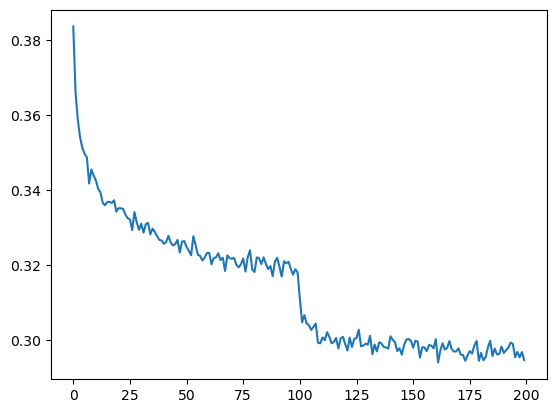

In [81]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [82]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [83]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str) -> None:
    """
    Given a split name, evaluates it and prints the result.
    Args:
        split(str): name of the dataset split you'd like to evaluate.
    """
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item()}')

In [84]:
split_loss('train')

train: 1.9652355909347534


In [85]:
# Sample from the model.
g = torch.Generator().manual_seed(13 + 10)
for _ in range (20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context])) # (1, block_size, n_embd)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '' token, break
        if ix == 0:
            break
    print("".join(itos[i] for i in out)) # decode and print the generated word

jamerie.
jlayna.
iviyah.
brair.
hazanai.
hawant.
liz.
elivyous.
neka.
jonashn.
laure.
ferylan.
sharenta.
haysen.
lavella.
jodua.
asikai.
romet.
telora.
segan.
